# Code for generating Figure 7 from derivative data

#### Raw code for generating derivative data is in 
`analysis5_model_traindat1dat2_richVsLazyLearning.py`
#### Batch script is in:
`analysis5_batch.sh`, line 35

#### Example command (within batch)

`python analysis5_model_traindat1dat2_richVsLazyLearning.py --weight_init 1.0 --bias_init 0 --nhidden 500 --normalize --cuda --outfilename analysis5_run${SLURM_ARRAY_TASK_ID}`

Note that weight_init needs to be varied according to parameters reported in Methods (0.2 to 2.0, in 0.2 increments)

Note that raw code is intended for use on a local Yale cluster, but is included in this repository for completeness

In this demo notebook, data for the analysis of trained ANN weights are not provided due to large file size. However, ANNs can be trained using the provided scripts.

In [1]:
import numpy as np
import nibabel as nib
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import nilearn.plotting as plotting
from importlib import reload
import wbplot
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import matplotlib.image as img 
import os
import h5py
import matplotlib.colors as clrs
from matplotlib import colorbar
plt.rcParams['font.sans-serif'] = "Arial"
from sklearn.preprocessing import PolynomialFeatures
import statsmodels.api as sm
import statsmodels.sandbox.stats.multicomp as mc
import sklearn
import dimensionality

#### Set up basic parameters

In [2]:
figuredir = '../figures/Fig7/'
if not os.path.exists(figuredir): os.makedirs(figuredir)

networkdef = np.loadtxt('cortex_parcel_network_assignments.txt')
# need to subtract one to make it compatible for python indices
indsort = np.loadtxt('cortex_community_order.txt',dtype=int) - 1 
indsort.shape = (len(indsort),1)

# network mappings for final partition set
networkmappings = {'fpn':7, 'vis1':1, 'vis2':2, 'smn':3, 'aud':8, 'lan':6, 'dan':5, 'con':4, 'dmn':9, 
                   'pmulti':10, 'none1':11, 'none2':12}
networks = networkmappings.keys()

xticks = {}
reorderednetworkaffil = networkdef[indsort]
for net in networks:
    netNum = networkmappings[net]
    netind = np.where(reorderednetworkaffil==netNum)[0]
    tick = np.max(netind)
    xticks[tick] = net

## General parameters/variables
nParcels = 360

sortednets = np.sort(list(xticks.keys()))
orderednetworks = []
for net in sortednets: orderednetworks.append(xticks[net])
    
networkpalette = ['royalblue','slateblue','paleturquoise','darkorchid','limegreen',
                  'lightseagreen','yellow','orchid','r','peru','orange','olivedrab']
networkpalette = np.asarray(networkpalette)
parcel_network_palette = []
for roi in range(nParcels): parcel_network_palette.append(networkpalette[int(networkdef[roi]-1)])

OrderedNetworks = ['VIS1','VIS2','SMN','CON','DAN','LAN','FPN','AUD','DMN','PMM','VMM','ORA']

glasserfilename = 'Q1-Q6_RelatedParcellation210.LR.CorticalAreas_dil_Colors.32k_fs_RL.dlabel.nii'
glasser = np.squeeze(nib.load(glasserfilename).get_fdata())

#### split up sensorimotor from association network color palettes
color1, color2 = sns.color_palette(palette='Pastel1')[1], sns.color_palette(palette='Pastel1')[0]
associationnets = ['con','dan','lan','fpn','dmn','pmulti','none1','none2']
sensorimotornets = ['vis1','vis2','smn','aud']
sensorynets = ['vis1','vis2','aud']
motornets = ['smn']

roi_id = np.zeros((nParcels,))
tmp = {}
netcount = 0
for network in networkmappings:
    net = np.where(networkdef==networkmappings[network])[0]
    for roi in net:
        if network in associationnets:
            tmp[roi] = color1 #'r'
            roi_id[roi] = -1
        else:
            tmp[roi] = color2 #'b'
            roi_id[roi] = 1
    netcount += 1
    
roiColorsByNetwork = []
for roi in range(len(networkdef)):
    roiColorsByNetwork.append(tmp[roi])
    
def calc_loglikelihood(n, y, ypred):
    lnL = 0.5 * (-n * (np.log(2*np.pi) + 1 - np.log(n) + np.log(sum((y-ypred)**2))));
    return lnL

def exponentialdecay(n0,decay,x):
    return n0*np.exp(-decay*x)

boxpalette = [sns.color_palette("Set2")[0], sns.color_palette("Set2")[2]]
    
subIDs = ['02','03','04','06','08','09','10','12','14','15','18','20','22','25','27','29','31','17','19','21','24','26','28','30']
sub_with_rest = ['02','03','06','08','10','12','14','18','20','22','24','25','26','27','28','29','30','31'] 

# Model params

In [3]:
nhidden = 500
nlayers = 10
outfilename = 'analysis5_run'
bias_init = '_biasinit0.0'
relu = ''
optim = '_optimadam'
normalize = '_normalize'
weight_init_range = [0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0]
untied = ''
nsimulations = 20

# Load RSMs & dimensionality of different initial weight conditions

In [4]:
model_rsms = []
df_dim_group = pd.DataFrame()
for weightinit in weight_init_range:
    model_rsms.append([])
    for sim in range(1,nsimulations+1):
        suffix = '_weightinit' + str(weightinit) + bias_init + optim + relu + normalize
        # Load dimensionality
        df_dim = pd.read_csv('../processed_data/analysis5_tiedweights/' + outfilename + str(sim) + '_data1and2_' + str(nhidden) + 'hidden_' + str(nlayers) + 'layers' + suffix + '_mse' + untied + '.csv')
        tmpdf = df_dim.groupby('Layer',as_index=False).mean()
        tmpdf.insert(loc=0,column='WeightInit', value=np.repeat(weightinit,12))
        tmpdf.insert(loc=0,column='Simulation', value=np.repeat(sim,12))

        df_dim_group = df_dim_group.append(tmpdf)
       

    
# Load in ANN RSMs    
h5f = h5py.File('../processed_data/analysis5_tiedweights/analysis5_ann_representations.h5','r')
model_rsms = h5f['data'][:].copy()
h5f.close()


# Calculate representational alignment across ANN layers

In [5]:
alllayers = model_rsms.shape[2]
triu_ind = np.triu_indices(45,k=0)
ra_mat = np.zeros((len(weight_init_range),nsimulations,alllayers,alllayers))
for weightinit in range(len(weight_init_range)):
    for sim in range(nsimulations):
        for layer1 in range(alllayers):
            for layer2 in range(alllayers):
                if layer2>layer1:
                    cosinesim = np.dot(model_rsms[weightinit,sim,layer1][triu_ind],model_rsms[weightinit,sim,layer2][triu_ind])/(np.linalg.norm(model_rsms[weightinit,sim,layer1][triu_ind]*np.linalg.norm(model_rsms[weightinit,sim,layer2][triu_ind])))
                    ra_mat[weightinit,sim,layer1,layer2] = cosinesim
        
        ra_mat[weightinit,sim] = ra_mat[weightinit,sim] + ra_mat[weightinit,sim].T
        np.fill_diagonal(ra_mat[weightinit,sim],1)
ra_mat_avg = np.mean(ra_mat,axis=1)

/var/folders/j_/sqyl0rss2cj2rbvf8gs3q1nh5b6ztc/T/ipykernel_91285/443725056.py:27: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, .9, 1])


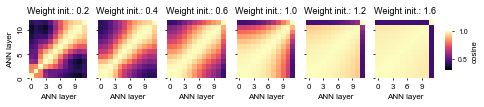

In [6]:
weights_to_plot = [0.2, 0.4, 0.6, 1.0, 1.2, 1.6]
vmin = np.min(ra_mat)
vmax = np.max(ra_mat)

fig, axn = plt.subplots(1, 6, sharex=True, sharey=True,figsize=(6.92,1.35))
cbar_ax = fig.add_axes([.9, .325, .015, .4])
i = 0
for weight in weights_to_plot:
    weight_ind = np.where(np.asarray(weight_init_range)==weight)[0][0]
    ax = axn.flat[i]
    tmpax = sns.heatmap(ra_mat_avg[weight_ind],square=True, ax=ax, cbar=i == 0, vmin=vmin, vmax=vmax, cmap='magma',cbar_ax=None if i else cbar_ax,cbar_kws={'fraction':0.04,'label':'cosine'})
    ax.set_title('Weight init.: ' + str(weight),fontsize=9)
    tmpax.invert_yaxis()
    tmpax.tick_params(size=2,labelsize=8)
    ax.set_yticks([0,5,10])
    ax.set_yticklabels([0,5,10])

    if i in [0,1,2,3,4, 5, 6, 7]: 
        ax.set_xlabel('ANN layer',size=8)
    if i in [0]:
        ax.set_ylabel('ANN layer', fontsize=8)
    
    i += 1
cax = plt.gcf().axes[-1]
cax.yaxis.label.set_size(8)
cax.tick_params(size=2,labelsize=7)
fig.tight_layout(rect=[0, 0, .9, 1])
fig.savefig(figuredir + 'ANN_RAMatrix_v2.pdf',transparent=True)



# Plot mean RA cosine across layers

Rich versus lazy, cosine difference: -0.12119219034799655
Rich vs. lazy, t = -124.70290578364514 | p = 3.789290162562279e-29


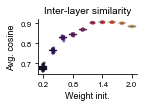

In [7]:
mean_cosine = {}
mean_cosine['Simulation'] = []
mean_cosine['Cosine'] = []
mean_cosine['Weight init.'] = []
mean_cosine['Training'] = []
i = 0
for weight in weight_init_range:
    ind = np.where(np.asarray(weight_init_range)==weight)[0][0]
    for sim in range(nsimulations):
        mean_cosine['Simulation'].append(sim)
        mean_cosine['Cosine'].append(np.mean(ra_mat[ind,sim]))
        mean_cosine['Weight init.'].append(weight)
        if weight < 1.0: 
            mean_cosine['Training'].append("Rich")
        elif weight > 1.0: 
            mean_cosine['Training'].append("Lazy")
        else: 
            mean_cosine['Training'].append("1.0")
    i += 1
    
plt.figure(figsize=(2.1 ,1.6))
ax = sns.boxplot(x='Weight init.', y='Cosine', data=mean_cosine, palette='magma', sym='',whis=[2.5,97.5],linewidth=0.25)
sns.stripplot(x='Weight init.', y='Cosine', data=mean_cosine, palette='magma',dodge=True,size=3,zorder=0,alpha=0.6)
plt.xticks(np.arange(0,len(weight_init_range),3),weight_init_range[::3],rotation=0,fontsize=8)
plt.xlabel('Weight init.',fontsize=9)
plt.ylabel('Avg. cosine', fontsize=9);
plt.yticks(fontsize=8)
plt.title('Inter-layer similarity',fontsize=10)
plt.tight_layout()
sns.despine()
plt.savefig(figuredir + 'LayerCosine_Vs_WeightInitialization.pdf',transparent=True)

### Run rich v. lazy statistics
mean_cosine = pd.DataFrame(mean_cosine)
tmprich = mean_cosine.loc[mean_cosine.Training=='Rich']
tmprich = tmprich.groupby(by="Simulation").mean()
tmplazy = mean_cosine.loc[mean_cosine.Training=='Lazy']
tmplazy = tmplazy.groupby(by="Simulation").mean()
t, p = stats.ttest_rel(tmprich.Cosine.values,tmplazy.Cosine.values)
print('Rich versus lazy, cosine difference:', np.mean(tmprich.Cosine.values)-np.mean(tmplazy.Cosine.values))
print("Rich vs. lazy, t =", t, '| p =', p)

# Plot scree plots for each matrix

Rich versus lazy, Variance explained difference: -0.15519227085002174
Rich vs. lazy, t = -99.09704361680139 | p = 2.966622894335642e-27


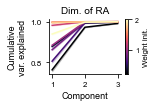

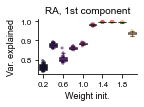

In [8]:
n_components = 3
df_pca = {}
df_pca['Weight init.'] = []
df_pca['Variance explained'] = []
df_pca['Component'] = []
df_pca['Simulation'] = []
df_pca['Training'] = []

principal_gradient_loadings = np.zeros((12,len(weight_init_range),nsimulations))

for sim in range(nsimulations):
    i = 0
    for weight in weight_init_range:
        weight_ind = np.where(np.asarray(weight_init_range)==round(weight,1))[0][0]
        pca = sklearn.decomposition.PCA(n_components=n_components)
        pca.fit(ra_mat[weight_ind,sim,:,:])
        var_explained = 0
        for comp in range(n_components):
            if comp==0: principal_gradient_loadings[:,i,sim] = pca.components_[0]
            var_explained += pca.explained_variance_ratio_[comp]
            df_pca['Weight init.'].append(round(weight,1))
            df_pca['Variance explained'].append(var_explained)
            df_pca['Component'].append(comp)
            df_pca['Simulation'].append(sim)
            if weight < 1.0: 
                df_pca['Training'].append("Rich")
            elif weight > 1.0: 
                df_pca['Training'].append("Lazy")
            else: 
                df_pca['Training'].append("1.0")
        i += 1
    
df_pca = pd.DataFrame(df_pca)

fig = plt.figure(figsize=(2.3,1.6))
# ax = plt.subplot(1,1,1,)
ax = sns.lineplot(x="Component",y="Variance explained",hue="Weight init.",data=df_pca,palette='magma',legend=False)
plt.xticks(np.arange(0,n_components),np.arange(1,n_components+1),fontsize=8)
plt.yticks(fontsize=8)
plt.title('Dim. of RA',fontsize=10);
plt.xlabel('Component',fontsize=9)
plt.ylabel('Cumulative\nvar. explained',fontsize=9)

norm = plt.Normalize(df_pca['Weight init.'].min(), df_pca['Weight init.'].max())
sm = plt.cm.ScalarMappable(cmap="magma", norm=norm)
sm.set_array([])
cax = ax.figure.colorbar(sm)
cax.ax.tick_params(labelsize=7)
cax.ax.set_ylabel('Weight init.', fontsize=8);
plt.tight_layout()
sns.despine()
plt.savefig(figuredir + 'ANNLayer_Screeplot.pdf',transparent=True)


tmpdf = df_pca.loc[df_pca.Component==0]

fig = plt.figure(figsize=(2.1,1.6))
# ax = plt.subplot(1,1,1,)
ax = sns.boxplot(x="Weight init.",y="Variance explained",data=tmpdf,palette='magma',sym='',whis=[2.5,97.5],dodge=True,linewidth=0.5)
ax = sns.stripplot(x="Weight init.",y="Variance explained",data=tmpdf,palette='magma',size=3,zorder=0,alpha=0.6)
plt.xticks(np.arange(0,len(weight_init_range),2),weight_init_range[::2],fontsize=8)
# plt.yticks(fontsize=8)
plt.title('RA, 1st component',fontsize=10);
# plt.xlabel('Component',fontsize=9)
plt.xlabel('Weight init.',fontsize=9)
plt.ylabel('Var. explained',fontsize=9)
ax.tick_params(axis='x',labelsize=8,rotation=0)
ax.tick_params(axis='y',labelsize=8,rotation=0)
sns.despine()
plt.tight_layout()
plt.savefig(figuredir + 'ANNLayer_1stCompVarExplained.pdf',transparent=True)

### Run rich v. lazy statistics
tmprich = tmpdf.loc[tmpdf.Training=='Rich']
tmprich = tmprich.groupby(by="Simulation").mean()
tmplazy = tmpdf.loc[tmpdf.Training=='Lazy']
tmplazy = tmplazy.groupby(by="Simulation").mean()
t, p = stats.ttest_rel(tmprich['Variance explained'].values,tmplazy['Variance explained'].values)
print('Rich versus lazy, Variance explained difference:', np.mean(tmprich['Variance explained'].values)-np.mean(tmplazy['Variance explained'].values))
print("Rich vs. lazy, t =", t, '| p =', p)

# Plot empirical brain RA matrix, sorted by gradient bins

In [9]:
# Load RA gradients
distance = 'cosine'
rsm_matrix = 'cosine'
rsm_gradients = np.loadtxt('../processed_data/analysis1/analysis1_' + distance + '_3components_' + rsm_matrix + 'RSMs_representational_gradients.csv')
# sorted_hierarchy = sorted(range(len(parcellated_gradients[:,1])), key=lambda k: parcellated_gradients[:,1][k])
sorted_hierarchy = sorted(range(len(rsm_gradients[:,0])), key=lambda k: rsm_gradients[:,0][k])

# Load RA matrix
rep_dist_mat_unthresh = np.loadtxt('../processed_data/analysis1/analysis1_' + distance + '_interregion_representational_distances_' + rsm_matrix + 'RSMs_unthresholded.csv')
# Load RSFC gradients, in case
parcellated_gradients = np.loadtxt('../processed_data/analysis1/analysis1_restFC_gradients.csv')


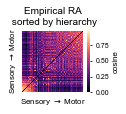

In [10]:
n_hierarchy_bins = 10
bin_stepsize = 36
sorted_hierarchy = sorted(range(len(rsm_gradients[:,0])), key=lambda k: rsm_gradients[:,0][k])
hierarchy_ind = np.asarray(sorted_hierarchy).copy()
hierarchy_ind.shape = (len(hierarchy_ind),1)

bin_ind = []
binstart = 0
for bins in range(n_hierarchy_bins):
    bin_ind.extend(sorted_hierarchy[binstart:binstart+bin_stepsize])
    binstart += bin_stepsize
bin_ind = np.asarray(bin_ind)
bin_ind.shape = (len(bin_ind),1)
indsort = bin_ind.copy()

sorted_mat = rep_dist_mat_unthresh[hierarchy_ind,hierarchy_ind.T]
plt.figure(figsize=(1.8,1.8))
ax = sns.heatmap(data=sorted_mat,square=True,cmap='magma',cbar=True,cbar_kws={"fraction":0.046,'label':'cosine'})
ax.invert_yaxis()
plt.title('Empirical RA\n sorted by hierarchy',fontsize=10)
plt.xlabel(r'Sensory $ \rightarrow $ Motor',fontsize=8);
plt.ylabel(r'Sensory $ \rightarrow $ Motor',fontsize=8);
plt.xticks([]);
plt.yticks([]);
cax = plt.gcf().axes[-1]
cax.yaxis.label.set_size(8)
cax.tick_params(size=2,labelsize=7)
plt.tight_layout()
plt.savefig(figuredir + 'EmpiricalRA_SortByBin.pdf',transparent=True)

# Now downsize into a 10x10 RA matrix (for each gradient bin)

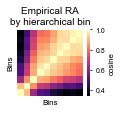

In [11]:
# Load emiprical RSMs
h5f = h5py.File('../processed_data/analysis1/analysis1_regional_rdms_cosine_allsubjs.h5','r')
rsms_subj = h5f['data'][:].copy()
h5f.close()
rsms_empirical = np.mean(np.arctanh(rsms_subj),axis=1)

gradbins = []
binstart = 0
for bins in range(n_hierarchy_bins):
    gradbins.append(sorted_hierarchy[binstart:binstart+bin_stepsize])
    binstart += bin_stepsize

rsms_empirical_downsize = []
for bins in range(n_hierarchy_bins):
    rsms_empirical_downsize.append(np.mean(rsms_empirical[gradbins[bins]],axis=0))

rsms_empirical_downsize = np.asarray(rsms_empirical_downsize)

triu_ind = np.triu_indices(45,k=0) # number of task conditions
ra_mat_downsize = np.zeros((10,10))
for bin_i in range(n_hierarchy_bins):                
    for bin_j in range(n_hierarchy_bins):
        ra_mat_downsize[bin_i,bin_j] = np.dot(rsms_empirical_downsize[bin_i][triu_ind],rsms_empirical_downsize[bin_j][triu_ind])/(np.linalg.norm(rsms_empirical_downsize[bin_i][triu_ind])*np.linalg.norm(rsms_empirical_downsize[bin_j][triu_ind]))

plt.figure(figsize=(1.8,1.8))
ax = sns.heatmap(data=ra_mat_downsize,square=True,cmap='magma',cbar=True,cbar_kws={"fraction":0.046,'label':'cosine'})
ax.invert_yaxis()
plt.title('Empirical RA\nby hierarchical bin',fontsize=10)
plt.xlabel('Bins',fontsize=8);
plt.ylabel('Bins',fontsize=8);
plt.xticks([]);
plt.yticks([]);
cax = plt.gcf().axes[-1]
cax.yaxis.label.set_size(8)
cax.tick_params(size=2,labelsize=7)
plt.tight_layout()
plt.savefig(figuredir + 'EmpiricalRA_Downsized_SortByBin.pdf',transparent=True)

___

# Supplementary analyses below

#### Derivative/processed data were not provided for trained ANN weights due to large data file size, but these models can be trained using provided scripts

#### Code below is shown for analytic completeness

# Assess weight statistics of ANNs for different initialization schemes

In [10]:
nhidden = 500
nlayers = 10
outfilename = 'analysis5_run'
bias_init = '_biasinit0.0'
relu = ''
optim = '_optimadam'
normalize = '_normalize'
weight_init_range = [0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0]
nsimulations = 20


nsubjs=24
nlayers=10
norm_mat = np.zeros((nsubjs,nsimulations,len(weight_init_range))) # nhidden X nlayers X subjs X simulations X weights
bias_mat = np.zeros((nsubjs,nsimulations,len(weight_init_range))) # nhidden X nlayers X subjs X simulations X weights

norm_mat_init = np.zeros((nsubjs,nsimulations,len(weight_init_range))) # nhidden X nlayers X subjs X simulations X weights
bias_mat_init = np.zeros((nsubjs,nsimulations,len(weight_init_range))) # nhidden X nlayers X subjs X simulations X weights

df_ann = {}
df_ann['Simulation'] = []
df_ann['WeightInitialization'] = []
df_ann['Training'] = []
df_ann['WeightNorm'] = []
df_ann['WeightMean'] = []
df_ann['WeightSD'] = []
df_ann['WeightKurtosis'] = []
df_ann['BiasNorm'] = []
df_ann['BiasMean'] = []
df_ann['BiasSD'] = []
df_ann['BiasKurtosis'] = []
df_ann['Regime'] = []

df_dist = {}
df_dist['WeightNorm'] = []
df_dist['WeightMean'] = []
df_dist['WeightInitialization'] = []

w = 0
for weightinit in weight_init_range:
    for sim in range(1,nsimulations+1):
        suffix = '_weightinit' + str(weightinit) + bias_init + optim + relu + normalize        
        h5f = h5py.File('../processed_data/analysis5_tiedweights/' + outfilename + str(sim) + '_data1and2_' + str(nhidden) + 'hidden_' + str(nlayers) + 'layers' + suffix + '_mse.h5','r')
        tmprsm = h5f['data'][:].copy()
        edge_mean, edge_norm, edge_sd, edge_kurtosis = h5f['edge_mean'][:].copy(), h5f['edge_norm'][:].copy(), h5f['edge_sd'][:].copy(), h5f['edge_kurtosis'][:].copy()
        bias_mean, bias_norm, bias_sd, bias_kurtosis = h5f['bias_mean'][:].copy(), h5f['bias_norm'][:].copy(), h5f['bias_sd'][:].copy(), h5f['bias_kurtosis'][:].copy()
        #
        edge_mean_init, edge_norm_init, edge_sd_init, edge_kurtosis_init = h5f['edge_mean_init'][:].copy(), h5f['edge_norm_init'][:].copy(), h5f['edge_sd_init'][:].copy(), h5f['edge_kurtosis_init'][:].copy()
        bias_mean_init, bias_norm_init, bias_sd_init, bias_kurtosis_init = h5f['bias_mean_init'][:].copy(), h5f['bias_norm_init'][:].copy(), h5f['bias_sd_init'][:].copy(), h5f['bias_kurtosis_init'][:].copy()
        h5f.close()
        
        norm_mat[:,sim-1,w] = np.mean(np.linalg.norm(edge_norm,axis=2),axis=1)
        bias_mat[:,sim-1,w] = np.mean(bias_norm,axis=1)
        
        norm_mat_init[:,sim-1,w] = np.mean(np.linalg.norm(edge_norm,axis=2),axis=1)
        bias_mat_init[:,sim-1,w] = np.mean(bias_norm_init,axis=1)
        
        df_dist['WeightNorm'].extend(np.mean(edge_norm,axis=1).reshape(-1))
        df_dist['WeightMean'].extend(np.mean(edge_mean,axis=1).reshape(-1))
        df_dist['WeightInitialization'].extend(np.repeat(weightinit,len(np.mean(edge_mean,axis=1).reshape(-1))))
        
        df_ann['Simulation'].append(sim)
        df_ann['WeightInitialization'].append(weightinit)
        df_ann['Training'].append('Trained')
        df_ann['WeightNorm'].append(np.mean(np.linalg.norm(edge_norm,axis=2)))
        df_ann['WeightMean'].append(np.mean(np.mean(edge_mean,axis=2)))
        df_ann['WeightSD'].append(np.mean(np.mean(edge_sd,axis=2)))
        df_ann['WeightKurtosis'].append(np.mean(np.mean(edge_kurtosis,axis=2)))
        df_ann['BiasNorm'].append(np.mean(bias_norm))
        df_ann['BiasMean'].append(np.mean(bias_mean))
        df_ann['BiasSD'].append(np.mean(bias_sd))
        df_ann['BiasKurtosis'].append(np.mean(bias_kurtosis))
        if weightinit<1.0:
            df_ann['Regime'].append('Rich')
        elif weightinit>1.0:
            df_ann['Regime'].append('Lazy')
        else:
            df_ann['Regime'].append('1.0')
            
        df_ann['Simulation'].append(sim)
        df_ann['WeightInitialization'].append(weightinit)
        df_ann['Training'].append('Untrained')
        df_ann['WeightNorm'].append(np.mean(np.linalg.norm(edge_norm_init,axis=2)))
        df_ann['WeightMean'].append(np.mean(np.mean(edge_mean_init,axis=2)))
        df_ann['WeightSD'].append(np.mean(np.mean(edge_sd_init,axis=2)))
        df_ann['WeightKurtosis'].append(np.mean(np.mean(edge_kurtosis_init,axis=2)))
        df_ann['BiasNorm'].append(np.mean(bias_norm_init))
        df_ann['BiasMean'].append(np.mean(bias_mean_init))
        df_ann['BiasSD'].append(np.mean(bias_sd_init))
        df_ann['BiasKurtosis'].append(np.mean(bias_kurtosis_init))
        if weightinit<1.0:
            df_ann['Regime'].append('Rich')
        elif weightinit>1.0:
            df_ann['Regime'].append('Lazy')
        else:
            df_ann['Regime'].append('1.0')

    w += 1
        
df_ann = pd.DataFrame(df_ann)
df_trained = df_ann.loc[df_ann.Training=='Trained']
df_untrained = df_ann.loc[df_ann.Training=='Untrained']

df_dist = pd.DataFrame(df_dist)

Rich versus lazy, Relative Kurtosis Change RICH: 0.2727933220565319
Rich versus lazy, Relative Kurtosis Change LAZY: 0.0012781133316457267
Rich versus lazy, Relative Kurtosis Change: 0.27151520872488616
	Rich vs. lazy, t = 192.1997401654216 | p = 1.0272758688316004e-32
Rich versus lazy, Relative Norm Change RICH: 2.3695581793785094
Rich versus lazy, Relative Norm Change LAZY: -0.4001055908203128
Rich versus lazy, Relative Norm Change Diff: 2.769663770198822
	Rich vs. lazy, t = 3038.3770558471447 | p = 1.7171606284875693e-55


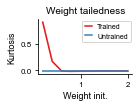

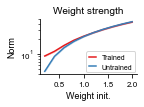

In [11]:
fig, ax = plt.subplots(figsize=(2.1,1.6))
ax1 = sns.lineplot(x="WeightInitialization",y="WeightKurtosis",hue="Training",data=df_ann, palette='Set1')
handles, labels = ax1.get_legend_handles_labels()
l = plt.legend(handles[-2:], labels[-2:], loc=1, borderaxespad=0.2, handlelength=1, prop={'size': 7})
ax.set_title('Weight tailedness', fontsize=10)
ax.set_ylabel('Kurtosis',fontsize=9)
ax.set_xlabel('Weight init.',fontsize=9)
ax.tick_params(labelsize=8)
plt.tight_layout()
sns.despine()
# plt.savefig(figuredir + 'WeightKurtosisVsWeightInit.pdf',transparent=True)

plt.figure(figsize=(2.1,1.6))
ax = sns.lineplot(x="WeightInitialization",y="WeightNorm",hue="Training",data=df_ann, palette='Set1')
handles, labels = ax.get_legend_handles_labels()
l = plt.legend(handles[-2:], labels[-2:], loc=4, borderaxespad=0.2, handlelength=1, prop={'size': 7})
ax.set_title('Weight strength', fontsize=10)
ax.set_ylabel('Norm',fontsize=9)
ax.set(yscale='log')
ax.set_xlabel('Weight init.',fontsize=9)
ax.tick_params(labelsize=8)
plt.tight_layout()
sns.despine()
# plt.savefig(figuredir + 'WeightNormVsWeightInit.pdf',transparent=True)

##### RELATIVE KURTOSIS CHANGE
### Run rich v. lazy statistics
tmprich_trained = df_ann.loc[(df_ann.Regime=='Rich') & (df_ann.Training=='Trained')]
tmprich_trained = tmprich_trained.groupby(by="Simulation").mean()
tmprich_untrained = df_ann.loc[(df_ann.Regime=='Rich') & (df_ann.Training=='Untrained')]
tmprich_untrained = tmprich_untrained.groupby(by="Simulation").mean()
tmprich_relative = tmprich_trained.WeightKurtosis.values - tmprich_untrained.WeightKurtosis.values

tmplazy_trained = df_ann.loc[(df_ann.Regime=='Lazy') & (df_ann.Training=='Trained')]
tmplazy_trained = tmplazy_trained.groupby(by="Simulation").mean()
tmplazy_untrained = df_ann.loc[(df_ann.Regime=='Lazy') & (df_ann.Training=='Untrained')]
tmplazy_untrained = tmplazy_untrained.groupby(by="Simulation").mean()
tmplazy_relative = tmplazy_trained.WeightKurtosis.values - tmplazy_untrained.WeightKurtosis.values

t, p = stats.ttest_rel(tmprich_relative,tmplazy_relative)
print('Rich versus lazy, Relative Kurtosis Change RICH:', np.mean(tmprich_relative))
print('Rich versus lazy, Relative Kurtosis Change LAZY:', np.mean(tmplazy_relative))
print('Rich versus lazy, Relative Kurtosis Change:', np.mean(tmprich_relative)-np.mean(tmplazy_relative))
print("\tRich vs. lazy, t =", t, '| p =', p)

##### RELATIVE NORM CHANGE
### Run rich v. lazy statistics
tmprich_trained = df_ann.loc[(df_ann.Regime=='Rich') & (df_ann.Training=='Trained')]
tmprich_trained = tmprich_trained.groupby(by="Simulation").mean()
tmprich_untrained = df_ann.loc[(df_ann.Regime=='Rich') & (df_ann.Training=='Untrained')]
tmprich_untrained = tmprich_untrained.groupby(by="Simulation").mean()
tmprich_relative = tmprich_trained.WeightNorm.values - tmprich_untrained.WeightNorm.values

tmplazy_trained = df_ann.loc[(df_ann.Regime=='Lazy') & (df_ann.Training=='Trained')]
tmplazy_trained = tmplazy_trained.groupby(by="Simulation").mean()
tmplazy_untrained = df_ann.loc[(df_ann.Regime=='Lazy') & (df_ann.Training=='Untrained')]
tmplazy_untrained = tmplazy_untrained.groupby(by="Simulation").mean()
tmplazy_relative = tmplazy_trained.WeightNorm.values - tmplazy_untrained.WeightNorm.values

t, p = stats.ttest_rel(tmprich_relative,tmplazy_relative)
print('Rich versus lazy, Relative Norm Change RICH:', np.mean(tmprich_relative))
print('Rich versus lazy, Relative Norm Change LAZY:', np.mean(tmplazy_relative))
print('Rich versus lazy, Relative Norm Change Diff:', np.mean(tmprich_relative)-np.mean(tmplazy_relative))
print("\tRich vs. lazy, t =", t, '| p =', p)

# Plot singular values of weight matrices

In [17]:
n_svalues = 50
df_svd = {}
df_svd['init'] = []
df_svd['sim'] = []
df_svd['singular'] = []
df_svd['singular range'] = []

w = 0
for weightinit in weight_init_range:
    for sim in range(1,nsimulations+1):
        suffix = '_weightinit' + str(weightinit) + bias_init + optim + relu + normalize    
        try:
            h5f = h5py.File(basedir + 'derivatives/results/analysis5_tiedweights/' + outfilename + str(sim) + '_data1and2_' + str(nhidden) + 'hidden_' + str(nlayers) + 'layers' + suffix + '_mse.h5','r')
            weights = h5f['weights'][:].copy()
            SVD = sklearn.decomposition.TruncatedSVD(n_svalues)
            SVD.fit(weights)
            svalues = SVD.explained_variance_ratio_
            df_svd['init'].extend(np.repeat(weightinit,n_svalues))
            df_svd['sim'].extend(np.repeat(sim,n_svalues))
            df_svd['singular'].extend(svalues)
            df_svd['singular range'].extend(np.arange(n_svalues))
            h5f.close()
        except:
            print(basedir + 'derivatives/results/analysis5_tiedweights/' + outfilename + str(sim) + '_data1and2_' + str(nhidden) + 'hidden_' + str(nlayers) + 'layers' + suffix + '_mse.h5')

df_svd = pd.DataFrame(df_svd)

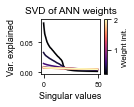

In [18]:
fig = plt.figure(figsize=(2.0,1.6))
ax = sns.lineplot(x='singular range', y ='singular', hue='init', data=df_svd,legend=False,palette='magma')
ax.set_ylabel('Var. explained', fontsize=9)
ax.set_xlabel('Singular values', fontsize=9)
ax.tick_params(labelsize=7)
ax.set_title('SVD of ANN weights',fontsize=10)

norm = plt.Normalize(df_svd['init'].min(), df_svd['init'].max())
sm = plt.cm.ScalarMappable(cmap="magma", norm=norm)
sm.set_array([])
cax = ax.figure.colorbar(sm)
cax.ax.tick_params(labelsize=7)
cax.ax.set_ylabel('Weight init.', fontsize=8);
plt.tight_layout()
# plt.savefig(figuredir + 'ANN_WeightSVD.pdf',transparent=True)

In [19]:
df_dim = {}
df_dim['init'] = []
df_dim['sim'] = []
df_dim['dimensionality'] = []
df_dim['training'] = []

w = 0
for weightinit in weight_init_range:
# for weightinit in [0.2, ]:
    for sim in range(1,nsimulations+1):
        suffix = '_weightinit' + str(weightinit) + bias_init + optim + relu + normalize    
        try:
            h5f = h5py.File(basedir + 'derivatives/results/analysis5_tiedweights/' + outfilename + str(sim) + '_data1and2_' + str(nhidden) + 'hidden_' + str(nlayers) + 'layers' + suffix + '_mse.h5','r')
            weights = h5f['weights'][:].copy()
            h5f.close()

            mat = np.cov(weights)
            dim = dimensionality.getDimensionality(mat)
            svalues = SVD.explained_variance_ratio_
            df_dim['init'].append(weightinit)
            df_dim['sim'].append(sim)
            df_dim['dimensionality'].append(dim)
            if weightinit<1.0:
                df_dim['training'].append('Rich')
            elif weightinit>1.0:
                df_dim['training'].append('Lazy')
            else: 
                df_dim['training'].append(1.0)
        except:
            print(basedir + 'derivatives/results/analysis5_tiedweights/' + outfilename + str(sim) + '_data1and2_' + str(nhidden) + 'hidden_' + str(nlayers) + 'layers' + suffix + '_mse.h5')

df_dim = pd.DataFrame(df_dim)

Rich Dimensionality: 142.31330420145127
Lazy Dimensionality: 247.92180588892205
Rich versus lazy, Dimensionality: -105.60850168747078
Rich vs. lazy, t = -913.8587629295677 | p = 1.406755988813277e-45


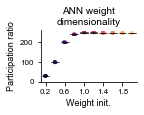

In [26]:
fig, ax1 = plt.subplots(figsize=(2.1,1.7))
ax = sns.boxplot(x='init',y='dimensionality',data=df_dim,palette='magma',sym='',whis=[2.5,97.5],linewidth=0.5)
ax = sns.stripplot(x='init',y='dimensionality',data=df_dim,palette='magma',size=3,zorder=0,alpha=0.6)
plt.xticks(np.arange(0,len(weight_init_range),2),weight_init_range[::2],fontsize=8)
# plt.yticks(fontsize=8)
plt.title('ANN weight\ndimensionality',fontsize=10);
# plt.xlabel('Component',fontsize=9)
plt.xlabel('Weight init.',fontsize=9)
plt.ylabel('Participation ratio',fontsize=9)
ax.tick_params(axis='x',labelsize=8,rotation=0)
ax.tick_params(axis='y',labelsize=8,rotation=0)
plt.ylim([0,260])
plt.tight_layout()
sns.despine()
plt.savefig(figuredir + 'ANNWeightDimensionality.pdf',transparent=True)

### Run rich v. lazy statistics
tmprich = df_dim.loc[df_dim.training=='Rich']
tmprich = tmprich.groupby(by="sim").mean()
tmplazy = df_dim.loc[df_dim.training=='Lazy']
tmplazy = tmplazy.groupby(by="sim").mean()
t, p = stats.ttest_rel(tmprich['dimensionality'].values,tmplazy['dimensionality'].values)
print('Rich Dimensionality:', np.mean(tmprich['dimensionality'].values))
print('Lazy Dimensionality:', np.mean(tmplazy['dimensionality'].values))
print('Rich versus lazy, Dimensionality:', np.mean(tmprich['dimensionality'].values)-np.mean(tmplazy['dimensionality'].values))
print("Rich vs. lazy, t =", t, '| p =', p)